In [1]:
from pathlib import Path
import czifile
import napari
import numpy as np
import skimage
from skimage import measure, exposure
from skimage.measure import regionprops_table
from cellpose import models
import pandas as pd
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt

# Select a GPU with the following in the name. This will fallback to any other GPU if none with this name is found
cle.select_device("RTX")

c:\Users\albertds\mambaforge\envs\microglia\lib\site-packages\pyclesperanto_prototype\_tier0\_device.py:77: UserWarning: No OpenCL device found with RTX in their name. Using Intel(R) UHD Graphics 630 instead.
  warnings.warn(f"No OpenCL device found with {name} in their name. Using {device.name} instead.")


<Intel(R) UHD Graphics 630 on Platform: Intel(R) OpenCL HD Graphics (1 refs)>

In [2]:
directory_path = Path("./raw_data/")
images = []

# Iterate through the lsm files in the directory
for file_path in directory_path.glob("*.czi"):
    images.append(str(file_path))
    
images

['raw_data\\well 1.czi',
 'raw_data\\well 10.czi',
 'raw_data\\well 11.czi',
 'raw_data\\well 12.czi',
 'raw_data\\well 13.czi',
 'raw_data\\well 14.czi',
 'raw_data\\well 15.czi',
 'raw_data\\well 2.czi',
 'raw_data\\well 3.czi',
 'raw_data\\well 4.czi',
 'raw_data\\well 5.czi',
 'raw_data\\well 6.czi',
 'raw_data\\well 7.czi',
 'raw_data\\well 8.czi',
 'raw_data\\well 9.czi']

In [11]:
image = images[0]

# Extract filename and well_id
file_path = Path(image)
filename = file_path.stem
well_id = filename.split(" ")[1]

# Read the image file and remove singleton dimensions
img = czifile.imread(image)
img = img.squeeze()

# Image size reduction to improve processing times (slicing, not lossless compression)
slicing_factor = 2 # Use 2 or 4 for compression (None for lossless)

# Extract the stack containing the nuclei (0), dna_damage (1) and microglia channel (2)
ki67_stack = img[0, :, ::slicing_factor, ::slicing_factor]
nuclei_stack = img[2, :, ::slicing_factor, ::slicing_factor]
caspase_stack = img[3, :, ::slicing_factor, ::slicing_factor]

# Perform maximum intensity projections
ki67_mip = np.max(ki67_stack, axis = 0)
nuclei_mip = np.max(nuclei_stack, axis = 0)
caspase_mip = np.max(caspase_stack, axis = 0)

In [10]:
viewer = napari.Viewer(ndisplay=2)
viewer.add_image(nuclei_stack)

<Image layer 'nuclei_stack' at 0x173a849d8b0>

In [4]:
# Initialize Napari Viewer
# viewer = napari.Viewer(ndisplay=2)
# Initialize Cellpose 2.0 model
# model = models.Cellpose(gpu=True, model_type="nuclei")

In [5]:
# # Apply Contrast Stretching to improve Cellpose detection of overly bright nuclei
# p2, p98 = np.percentile(nuclei_mip, (2, 98))
# img_rescale = exposure.rescale_intensity(nuclei_mip, in_range=(p2, p98))

# # Predict nuclei nuclei_masks using cellpose
# nuclei_masks, flows, styles, diams = model.eval(img_rescale, diameter=None, channels=[0, 0], net_avg=False)

# viewer.add_labels(nuclei_masks)

# print(diams)

In [6]:
# gaussian_sigma = 20

# # Might need to perform a Gaussian-blur before
# post_gaussian_img = skimage.filters.gaussian(nuclei_mip, sigma=gaussian_sigma)

# viewer.add_image(post_gaussian_img)

In [7]:

# # Initialize Cellpose 2.0 model
# model = models.Cellpose(gpu=True, model_type="nuclei")

# # Predict nuclei nuclei_masks using cellpose
# nuclei_masks, flows, styles, diams = model.eval(nuclei_stack, diameter=None, channels=[0, 0], net_avg=False, do_3D=True)


# # Initialize Napari Viewer
# viewer = napari.Viewer(ndisplay=2)
# viewer.add_image(nuclei_stack)
# viewer.add_labels(nuclei_masks)

# print(diams)

In [12]:
#TODO: Make 3D stack isotropic

# Voxel size from .czi file metadata
input_image = nuclei_stack

voxel_size_x = 0.21
voxel_size_y = 0.21
voxel_size_z = 2.17

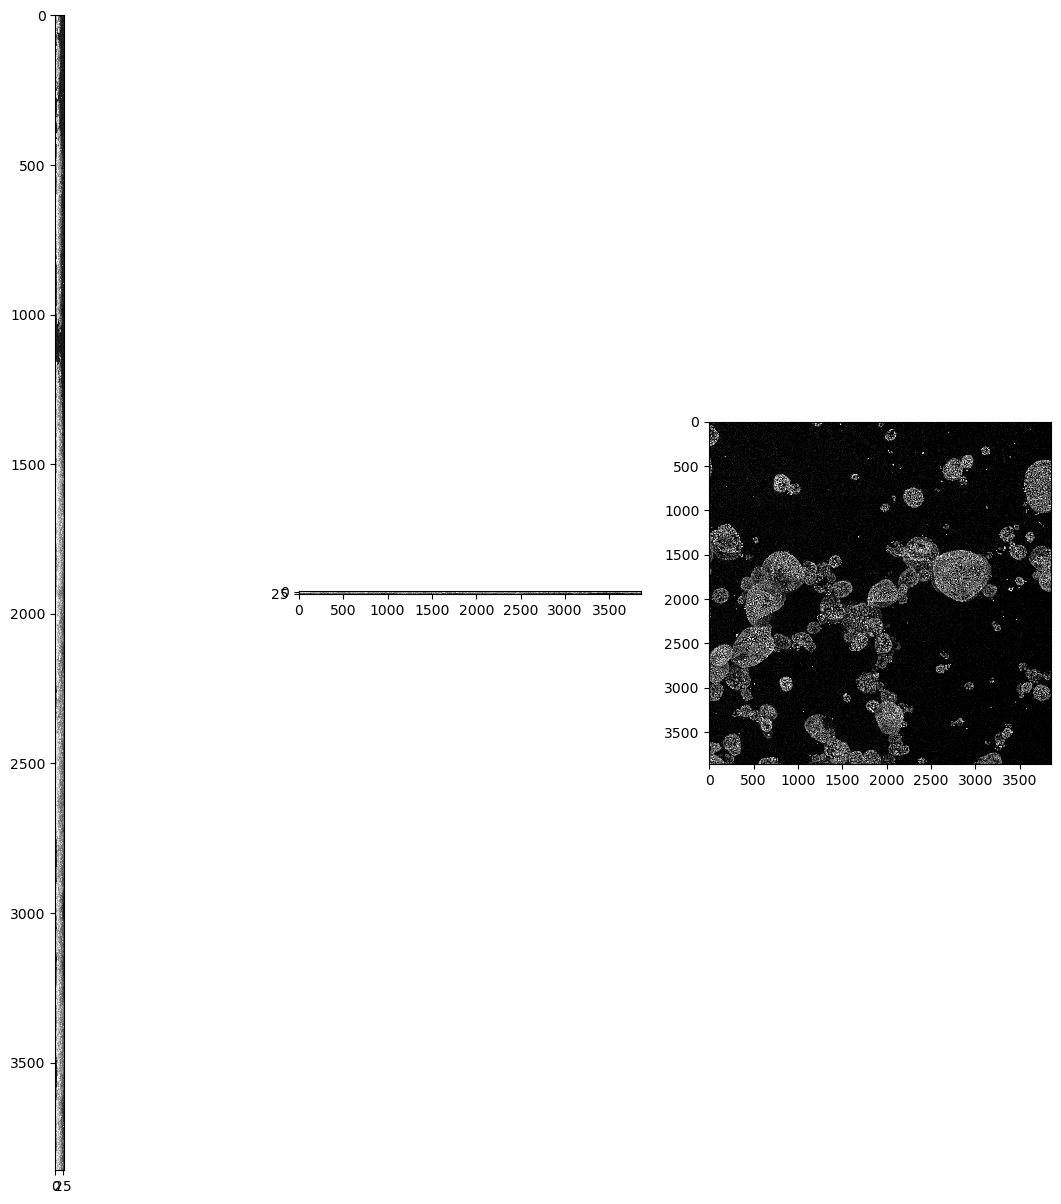

(29, 3860, 3856)


In [13]:
def show(image_to_show, labels=False):
    """
    This function generates three projections: in X-, Y- and Z-direction and shows them.
    """
    projection_x = cle.maximum_x_projection(image_to_show)
    projection_y = cle.maximum_y_projection(image_to_show)
    projection_z = cle.maximum_z_projection(image_to_show)

    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    cle.imshow(projection_x, plot=axs[0], labels=labels)
    cle.imshow(projection_y, plot=axs[1], labels=labels)
    cle.imshow(projection_z, plot=axs[2], labels=labels)
    plt.show()

show(input_image)
print(input_image.shape)


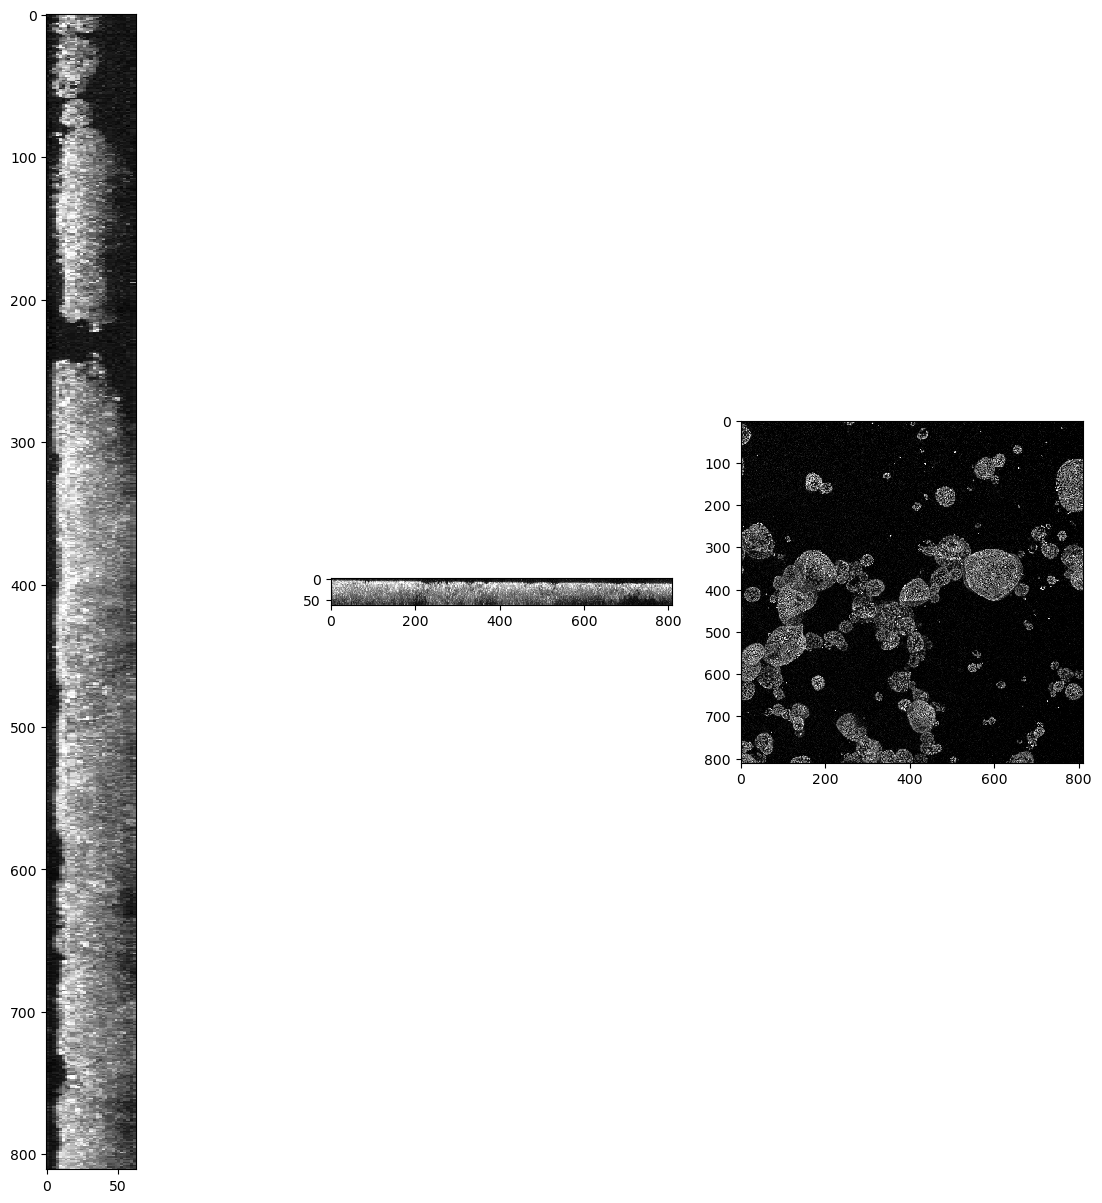

(63, 811, 810)


In [14]:
resampled = cle.scale(input_image, factor_x=voxel_size_x, factor_y=voxel_size_y, factor_z=voxel_size_z, auto_size=True)

show(resampled)
print(resampled.shape)

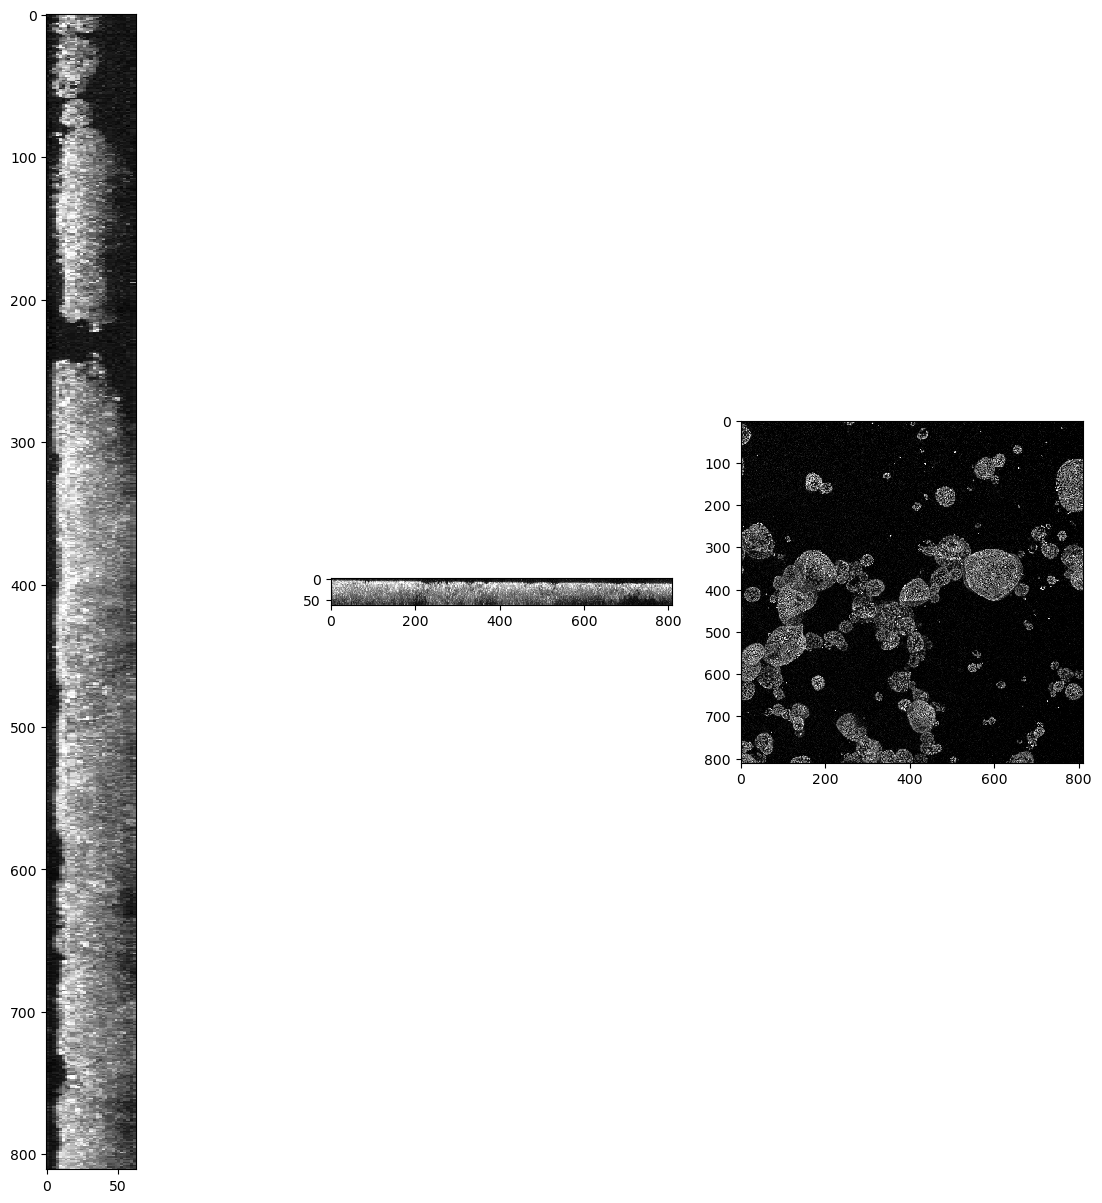

In [15]:
background_subtracted = cle.top_hat_box(resampled, radius_x=5, radius_y=5, radius_z=5)
show(background_subtracted)

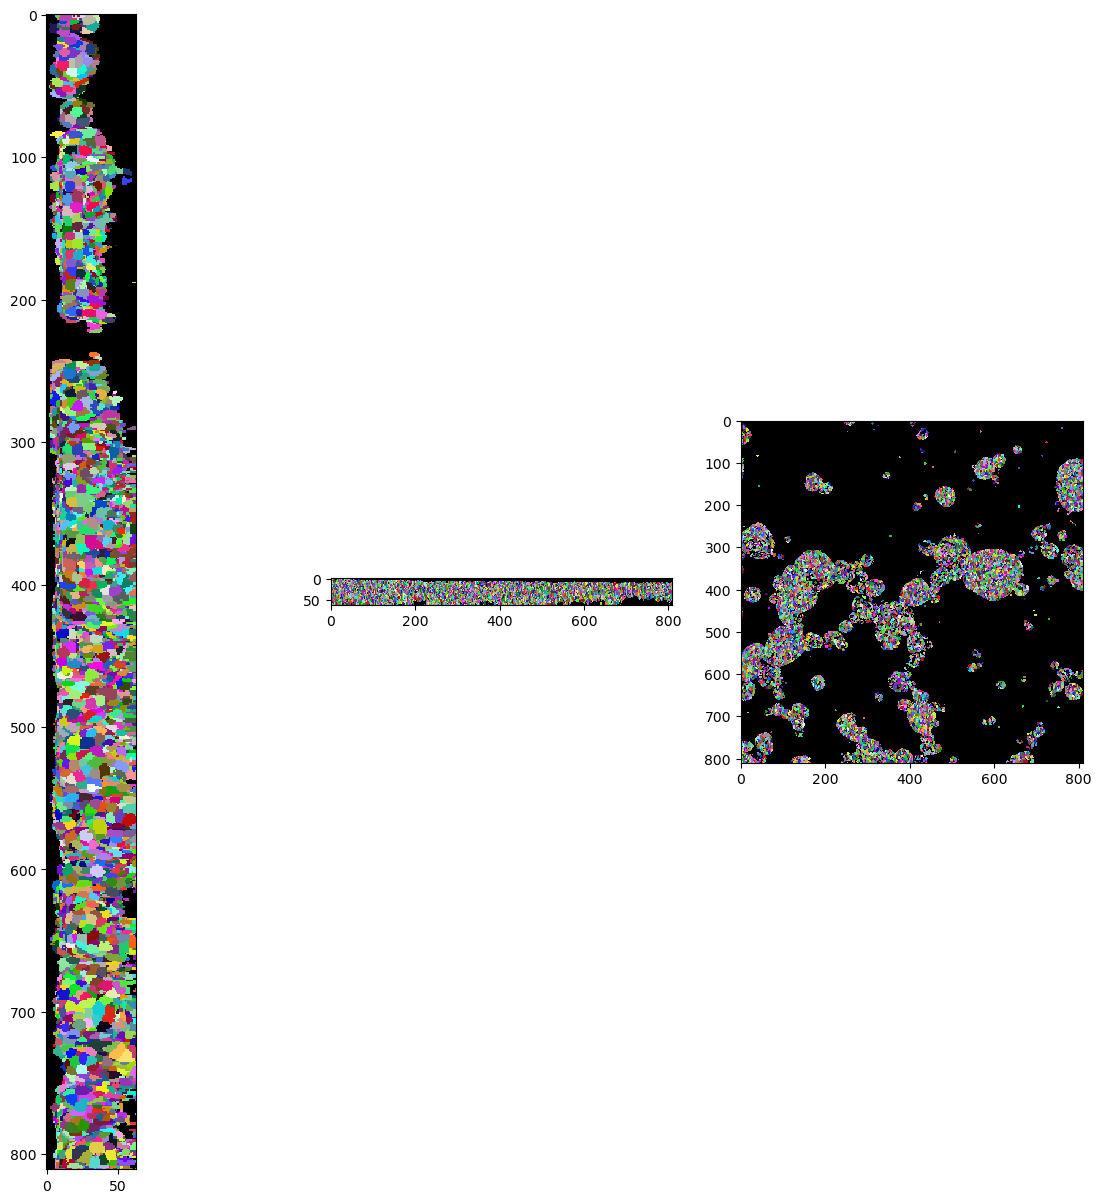

In [19]:
segmented = cle.voronoi_otsu_labeling(background_subtracted, spot_sigma=1, outline_sigma=1)
show(segmented, labels=True)

In [ ]:
a_slice = cle.create([resampled.shape[1], resampled.shape[0]])
segmented_slice = cle.create([resampled.shape[1], resampled.shape[0]])

for z in range(0, resampled.shape[2], 20):
    label_outlines = None
    combined = None

    # get a single slice from the intensity image and the segmented label image
    cle.copy_slice(resampled, a_slice, z)
    cle.copy_slice(segmented, segmented_slice, z)

    # determine outlines around labeled objects
    label_outlines = cle.detect_label_edges(segmented_slice, label_outlines)

    # combine both images
    outline_intensity_factor = cle.maximum_of_all_pixels(a_slice)
    combined = cle.add_images_weighted(a_slice, label_outlines, combined, 1.0, outline_intensity_factor)

    # visualisation
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    cle.imshow(a_slice, plot=axs[0])
    cle.imshow(segmented_slice, plot=axs[1], labels=True)
    cle.imshow(combined, plot=axs[2])

In [20]:
# start napari
viewer = napari.Viewer()

# show images
viewer.add_image(resampled)
viewer.add_labels(segmented)

<Labels layer 'segmented' at 0x178b1fefb20>